# Anomaly Detection with an Isolation Forest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Data Preparation

In [3]:
columns = ["duration", "protocol_type", "service", "flag",
"src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
"hot", "num_failed_logins", "logged_in", 
"num_compromised", "root_shell", "su_attempted", "num_root", 
"num_file_creations", "num_shells", 
"num_access_files", "num_outbound_cmds", "is_host_login",
"is_guest_login", "count", "srv_count", "serror_rate", 
"srv_serror_rate", "rerror_rate", "srv_rerror_rate",
"same_srv_rate", "diff_srv_rate", 
"srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
"dst_host_same_srv_rate", "dst_host_diff_srv_rate",
"dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
"dst_host_serror_rate", "dst_host_srv_serror_rate",
"dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv("./kddcup.data/kddcup.data.corrected", sep=",", names=columns, index_col=None)

Filter to only 'http' attacks

In [4]:
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)

In [5]:
df["label"].value_counts()

label
normal.       619046
back.           2203
neptune.        1801
portsweep.        16
ipsweep.          13
satan.             7
phf.               4
nmap.              1
Name: count, dtype: int64

Label of 'normal.' becomes 0, and anything else becomes 1 and is treated as an anomaly.

In [6]:
df['label'] = df['label'].apply(lambda x: 0 if x=='normal.' else 1)
df['label'].value_counts()

label
0    619046
1      4045
Name: count, dtype: int64

In [7]:
datatypes = dict(zip(df.dtypes.index, df.dtypes))

In [8]:
encoder_map = {}
for col, datatype in datatypes.items():
    if datatype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoder_map[col] = encoder

Check the variables with highest correlation with 'label'

In [9]:
df2 = df.copy()
label_corr = df2.corr()['label']

Filter out anything that has null entry or is not weakly correlated

In [12]:
train_cols = label_corr[(~label_corr.isna()) & (np.abs(label_corr) > 0.2)]
train_cols = list(train_cols[:-1].index)
train_cols

['src_bytes',
 'hot',
 'num_compromised',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate']

In [13]:
labels = df2['label']

Conduct a train-test split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df2[train_cols].values, labels.values, test_size=0.15, random_state=42)

Additional split of training dataset to create validation split

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [16]:
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(423701, 13)
y_train:(423701,)

x_val:(105926, 13)
y_val:(105926,)

x_test:(93464, 13)
y_test:(93464,)


# Training

Let's try out isolation forest with stock parameters. It may take a bit of time to train.

In [17]:
isolation_forest = IsolationForest(random_state=42)

In [18]:
isolation_forest.fit(x_train)
anomaly_scores = isolation_forest.decision_function(x_train)

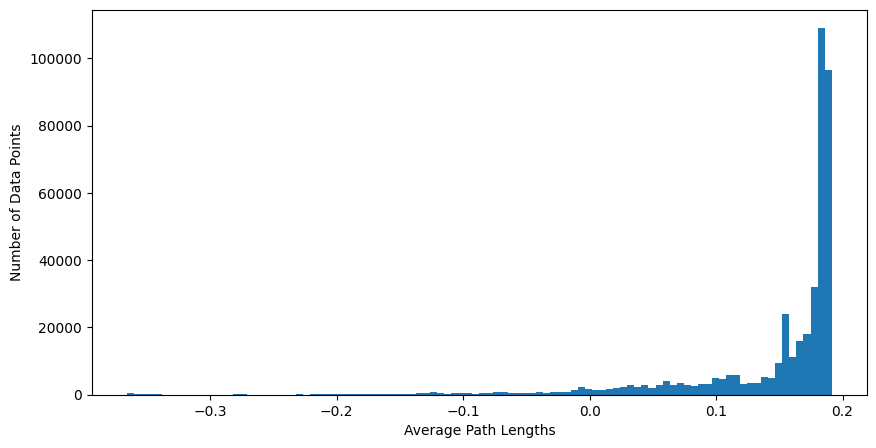

In [19]:
plt.figure(figsize=(10, 5))
plt.hist(anomaly_scores, bins=100)
plt.xlabel('Average Path Lengths')
plt.ylabel('Number of Data Points')
plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

In [21]:
threshold = -0.3
anomalies = anomaly_scores < threshold

precision = precision_score(y_train, anomalies)
recall = recall_score(y_train, anomalies)
f1 = f1_score(y_train, anomalies)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Measure: {f1}")

Precision: 1.0
Recall: 0.4050179211469534
F1-Measure: 0.576530612244898


# Hyperparameter Tuning

estimate proportion of anomalies. It's about 0.0065, 0.0066

In [22]:
(y_train==1).sum() / len(y_train)

0.006584832228387471

Given an isolation_forest instance, x, and y data, train and evaluate and return results

In [27]:
def experiment(isolation_forest, x, y):
    isolation_forest.fit(x)

    anomaly_scores = isolation_forest.decision_function(x)

    # Using a stock Logistic Regression model to predict labels
    lr = LogisticRegression()
    lr.fit(anomaly_scores.reshape(-1, 1), y)

    preds = lr.predict(anomaly_scores.reshape(-1, 1))

    pre = precision_score(y, preds)
    rec = recall_score(y, preds)
    f1 = f1_score(y, preds)

    return {'precision': pre, 'recall': rec, 'f1': f1}

Perform experimental search for max_samples

In [28]:
validation_results = {}
max_samples = [2**f for f in [8, 9, 10, 11, 12]]
for max_sample in max_samples:
    # We are fixing the n_estimators to 50 to be quicker. n_jobs=-1 lets us train on all cores
    isolation_forest = IsolationForest(n_estimators=50, max_samples=max_sample, n_jobs=-1, contamination=0.0066, random_state=42)

    res = experiment(isolation_forest, x_val, y_val)
    validation_results[max_sample] = res

Printing out the results of the validation. The optimal setting is between 512 and 4096

In [29]:
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(256, 0.5956175298804781),
 (512, 0.7805695142378559),
 (1024, 0.9556509298998569),
 (2048, 0.93361285814116),
 (4096, 0.777602523659306)]

Repeat validation with a narrower range

In [30]:
validation_results = {}
max_samples = range(500, 2200, 200)
for max_sample in max_samples:
    # We are fixing the n_estimators to 50 to be quicker. n_jobs=-1 lets us train on all cores
    isolation_forest = IsolationForest(n_estimators=50, max_samples=max_sample, n_jobs=-1, contamination=0.0066, random_state=42)

    res = experiment(isolation_forest, x_val, y_val)
    validation_results[max_sample] = res

In [31]:
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(500, 0.7133984028393966),
 (700, 0.7355163727959698),
 (900, 0.7577741407528642),
 (1100, 0.9556509298998569),
 (1300, 0.9362606232294618),
 (1500, 0.956397426733381),
 (1700, 0.9323098394975575),
 (1900, 0.8104374520337683),
 (2100, 0.8592483419307295)]

Repeat validation with a narrower range

In [32]:
validation_results = {}
max_samples = list(range(950, 1110, 10)) + list(range(1300, 1800, 100))
for max_sample in max_samples:
    # We are fixing the n_estimators to 50 to be quicker. n_jobs=-1 lets us train on all cores
    isolation_forest = IsolationForest(n_estimators=50, max_samples=max_sample, n_jobs=-1, contamination=0.0066, random_state=42)

    res = experiment(isolation_forest, x_val, y_val)
    validation_results[max_sample] = res

In [33]:
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(950, 0.9632299927901946),
 (960, 0.9618430525557955),
 (970, 0.9631768953068592),
 (980, 0.9604031677465803),
 (990, 0.9206819866567828),
 (1000, 0.9611510791366906),
 (1010, 0.9562096195262024),
 (1020, 0.9577060931899641),
 (1030, 0.9529243937232525),
 (1040, 0.9522451888809693),
 (1050, 0.8836858006042296),
 (1060, 0.9431245500359972),
 (1070, 0.9548387096774194),
 (1080, 0.9555236728837877),
 (1090, 0.9556509298998569),
 (1100, 0.9556509298998569),
 (1300, 0.9362606232294618),
 (1400, 0.9495380241648899),
 (1500, 0.956397426733381),
 (1600, 0.9468462083628633),
 (1700, 0.9323098394975575)]

Tuning max_features

In [34]:
validation_results = {}
max_features = range(5, 8, 1)
for max_feature in max_features:
    max_feature = max_feature / 10.0

    # We are fixing the n_estimators to 50 to be quicker. n_jobs=-1 lets us train on all cores
    isolation_forest = IsolationForest(n_estimators=50, max_samples=950, max_features=max_feature, n_jobs=-1, contamination=0.0066, random_state=42)

    res = experiment(isolation_forest, x_val, y_val)
    validation_results[max_feature] = res

In [35]:
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.5, 0.7455012853470437),
 (0.6, 0.9722627737226277),
 (0.7, 0.9693877551020408)]

Tuning max_features with a narrower range

In [36]:
validation_results = {}
max_features = range(55, 71, 1)
for max_feature in max_features:
    max_feature = max_feature / 100.0

    # We are fixing the n_estimators to 50 to be quicker. n_jobs=-1 lets us train on all cores
    isolation_forest = IsolationForest(n_estimators=50, max_samples=950, max_features=max_feature, n_jobs=-1, contamination=0.0066, random_state=42)

    res = experiment(isolation_forest, x_val, y_val)
    validation_results[max_feature] = res

In [37]:
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.55, 0.9722627737226277),
 (0.56, 0.9722627737226277),
 (0.57, 0.9722627737226277),
 (0.58, 0.9722627737226277),
 (0.59, 0.9722627737226277),
 (0.6, 0.9722627737226277),
 (0.61, 0.9722627737226277),
 (0.62, 0.9295154185022027),
 (0.63, 0.9295154185022027),
 (0.64, 0.9295154185022027),
 (0.65, 0.9295154185022027),
 (0.66, 0.9295154185022027),
 (0.67, 0.9295154185022027),
 (0.68, 0.9295154185022027),
 (0.69, 0.9295154185022027),
 (0.7, 0.9693877551020408)]

Tuning max_features with a narrower range

In [38]:
validation_results = {}
n_estimators = range(10, 110, 10)
for n_estimator in n_estimators:
    # We are fixing the n_estimators to 50 to be quick. n_jobs=-1 lets us train on all cores
    isolation_forest = IsolationForest(n_estimators=n_estimator, max_samples=950, max_features=0.55, n_jobs=-1, contamination=0.0066, random_state=42)

    res = experiment(isolation_forest, x_val, y_val)
    validation_results[n_estimator] = res

In [39]:
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(10, 0.9799851742031134),
 (20, 0.9765395894428153),
 (30, 0.9758241758241758),
 (40, 0.9743964886613021),
 (50, 0.9722627737226277),
 (60, 0.9743964886613021),
 (70, 0.9659173313995649),
 (80, 0.9542203147353362),
 (90, 0.9568965517241379),
 (100, 0.958963282937365)]

# Evaluation and Summary

Set our hyperparameters that we discovered during validation and train

In [41]:
isolation_forest = IsolationForest(n_estimators=10, max_samples=950, max_features=0.55, n_jobs=-1, contamination=0.0066, random_state=42)

isolation_forest.fit(x_train)
anomaly_scores = isolation_forest.decision_function(x_train)

lr = LogisticRegression()
lr.fit(anomaly_scores.reshape(-1, 1), y_train)

preds = lr.predict(anomaly_scores.reshape(-1, 1))

precision = precision_score(y_train, preds)
recall = recall_score(y_train, preds)
f1 = f1_score(y_train, preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Measure: {f1}")

Precision: 0.9760885082084225
Recall: 0.9802867383512545
F1-Measure: 0.9781831187410587


In [42]:
anomaly_scores = isolation_forest.decision_function(x_test)

preds = lr.predict(anomaly_scores.reshape(-1, 1))

precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Measure: {f1}")

Precision: 0.9773519163763066
Recall: 0.9859402460456942
F1-Measure: 0.9816272965879265


In [43]:
roc_auc_score(y_test, preds)

0.9929001515496785

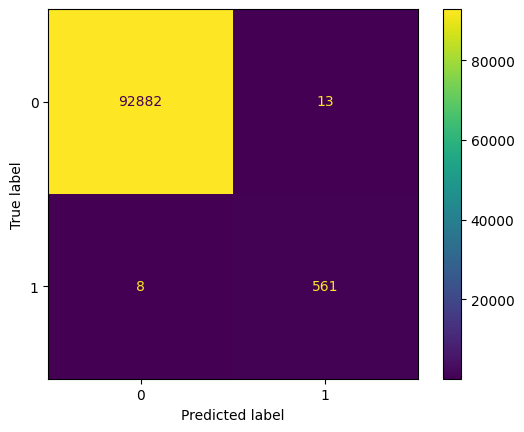

In [44]:
conf_mat = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()